In [1]:
import torch
import numpy as np
from torch import nn
import torch.nn.functional as F
from dynamics_env.dynamics_env import Dynamics
from tqdm import tqdm
import matplotlib.pyplot as plt
from dynamics_env.galaxy_models import PointSource
from scipy.integrate import solve_ivp

In [2]:
episode_length = 256
init_params = [0.48813504, 2.15189366, 1.02763376, 2.69299098, 4.58071204, 8.75364678]
memory_size = 1e4
lookahead_options = 4
device = torch.device('cuda' if torch.cuda.is_available and False else 'cpu')
seed = 0
weights_directory = 'runs/Dynamics-v0__straight_accs__0_weights/'
lookahead_steps = 4
gamma = 0.98
M = 10
orbit_timesteps = 1000
orbit_duration = 1000 # Myr

In [3]:
def make_env(gym_id, seed):
    def thunk():
        # env = gym.make(gym_id, hyperparameters={
        #     'galaxy_model_kwargs_list':[{'M':10}]
        # })
        env = Dynamics(hyperparameters={
            'galaxy_model_kwargs_list':[{'M':M}],
            'seed':seed,
        })
        env.action_space.seed(seed)
        env.observation_space.seed(seed)
        return env
    return thunk
source = PointSource(M)
def get_equations(t, w):
    x, y, z, vx, vy, vz = w
    ax, ay, az = source.get_acceleration(np.array([x, y, z]))
    return [vx, vy, vz, ax.item(), ay.item(), az.item()]
test_orbit = solve_ivp(get_equations, t_span=(0, orbit_duration), y0=init_params, t_eval=np.linspace(0, orbit_duration, orbit_timesteps)).y[:]

def denorm_state(state, env):
    return state*env.high

def out_of_bounds_damping(r_max):
        return np.e**(-1/env.high[0] / 1e3) if r_max < env.high[0] else np.e**(-r_max / env.high[0] / 1e3)

In [4]:
class Actor(nn.Module):
    def __init__(self, env, activation=nn.Tanh):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(np.array(env.observation_space.shape).prod(), 64),
            activation(),
            nn.Linear(64, 32),
            activation(),
            nn.Linear(32, env.action_space.shape[0] * 2)
        )
        self.out_shape = env.action_space.shape[0]
    def forward(self, X):
        X = self.model(X)
        (means, log_stds) = torch.split(X, [self.out_shape, self.out_shape], dim=-1)
        return means, log_stds.exp()

In [ ]:
def plot_from_init(init_params):
    orbit = solve_ivp(get_equations, t_span=(0, orbit_duration), y0=init_params, t_eval=np.linspace(0, orbit_duration, orbit_timesteps))
    init_params_delta = init_params + np.random.normal(scale=1e-8, size=len(init_params))
    orbit_delta = solve_ivp(get_equations, t_span=(0, orbit_duration), y0=init_params_delta, t_eval=np.linspace(0, orbit_duration, orbit_timesteps))
    # orbit_out_of_bounds_mask = np.abs(orbit.y[:3]) > np.expand_dims(env.high[:3], axis=-1)
    # orbit_delta_out_of_bounds_mask = np.abs(orbit_delta.y[:3]) > np.expand_dims(env.high[:3], axis=-1)
    # combined_mask = (orbit_out_of_bounds_mask * orbit_delta_out_of_bounds_mask).prod(axis=0)
    # if combined_mask.sum() == 0:
    #     last_index = len(combined_mask)
    # else:
    #     last_index = np.argmax(combined_mask)
    # if last_index < 10:
    #     reward = 0
    orbit_dists = np.linalg.norm(orbit.y - orbit_delta.y, axis=0)
    log_orbit_dists = np.log(orbit_dists + 1e-8)
    fit_coeffs = np.polyfit(orbit.t, log_orbit_dists, 1)
    max_r = np.max(np.linalg.norm(orbit.y[:3], axis=0))
    damping = out_of_bounds_damping(max_r)
    reward = fit_coeffs[0] * damping
    fig = plt.figure(figsize=(18, 6))
    ax1 = fig.add_subplot(131, projection='3d')
    ax1.plot(orbit.y[0], orbit.y[1], orbit.y[2], lw=0.5, label=r'$O$')
    ax1.plot(orbit_delta.y[0], orbit_delta.y[1], orbit_delta.y[2], lw=0.5, label=r'$O+\delta O$')
    ax1.scatter(init_params[0], init_params[1], init_params[2], label='Trajectory start')
    ax1.scatter(init_params_delta[0], init_params_delta[1], init_params_delta[2], label='Delta trajectory start')
    ax1.scatter(0, 0, 0, label='Source')
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Z')
    ax1.set_title(f'3D Orbit: {reward / orbit.y.shape[-1]}')
    ax1.legend()

    ax2 = fig.add_subplot(132)
    ax2.plot(orbit.y[0], orbit.y[1], lw=2, label=r'$O$')
    ax2.plot(orbit_delta.y[0], orbit_delta.y[1], lw=2, label=r'$O+\delta O$')
    ax2.scatter(init_params[0], init_params[1], label='Trajectory start')
    ax2.scatter(init_params_delta[0], init_params_delta[1], label='Delta trajectory start')
    ax2.scatter(0, 0, label='Source')
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.set_title('Projected Orbit')
    ax2.legend()

    ax3 = fig.add_subplot(133)
    ax3.plot(log_orbit_dists[:], lw=2, label=r'log$(\Delta X)$')
    X_fit = np.linspace(orbit.t[0], orbit.t[-1], 100)
    Y_fit = fit_coeffs[0] * X_fit + fit_coeffs[1]
    ax3.plot(X_fit, Y_fit, lw=2, label=r'Fit line')
    ax3.set_xlabel('logdist')
    ax3.set_ylabel('t')
    ax3.set_title(f'Logdists: {damping}')
    ax3.legend()

[ENV] Using cpu
[ENV] Seed set to 0
[-2.08831191e+00 -8.05759430e-01  1.00000000e+01 -4.86773886e-02
  1.49986774e-01 -5.29034063e-03]


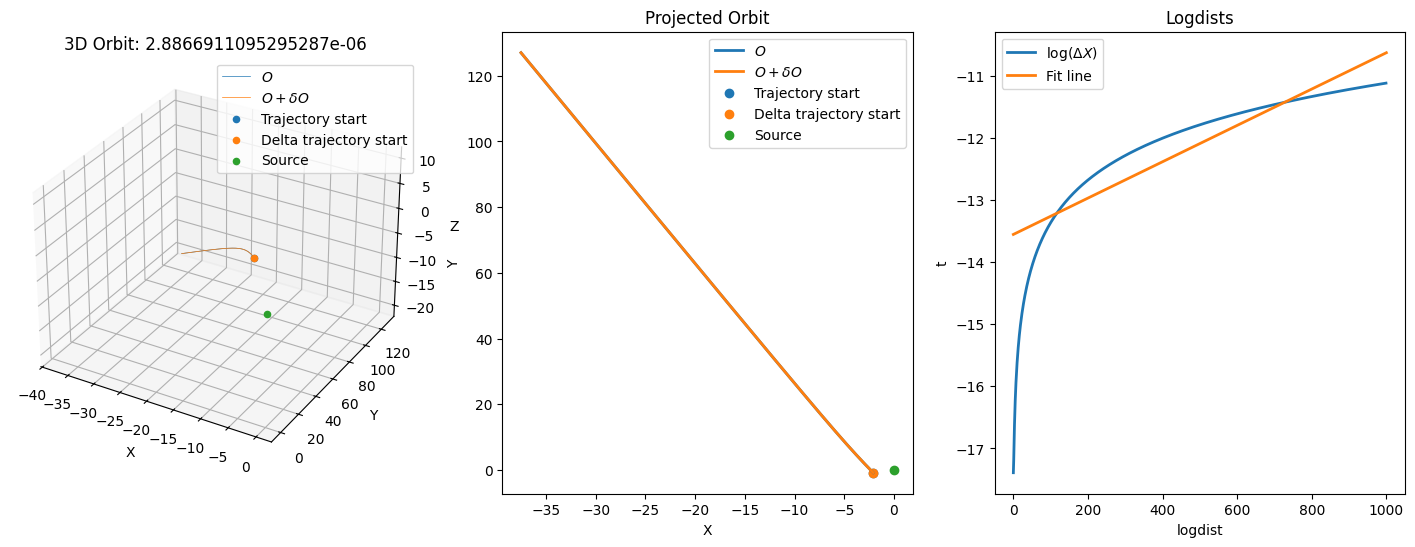

In [6]:
env = make_env(None, seed=seed)()
actor = Actor(env)
actor.load_state_dict(torch.load('runs/Dynamics-v0__ppo_single_step_weights/actor.pth'))
state, _ = env.reset([0,0,0,0,0,0])
with torch.no_grad():
    action_means, action_stds = actor(torch.tensor(state, dtype=torch.float32))
dist = torch.distributions.Normal(action_means, action_stds)
action = dist.sample()
state, reward, _, _, info = env.step(action.numpy())
print(state)
init_params = denorm_state(state, env)
init_params = state
plot_from_init(init_params)

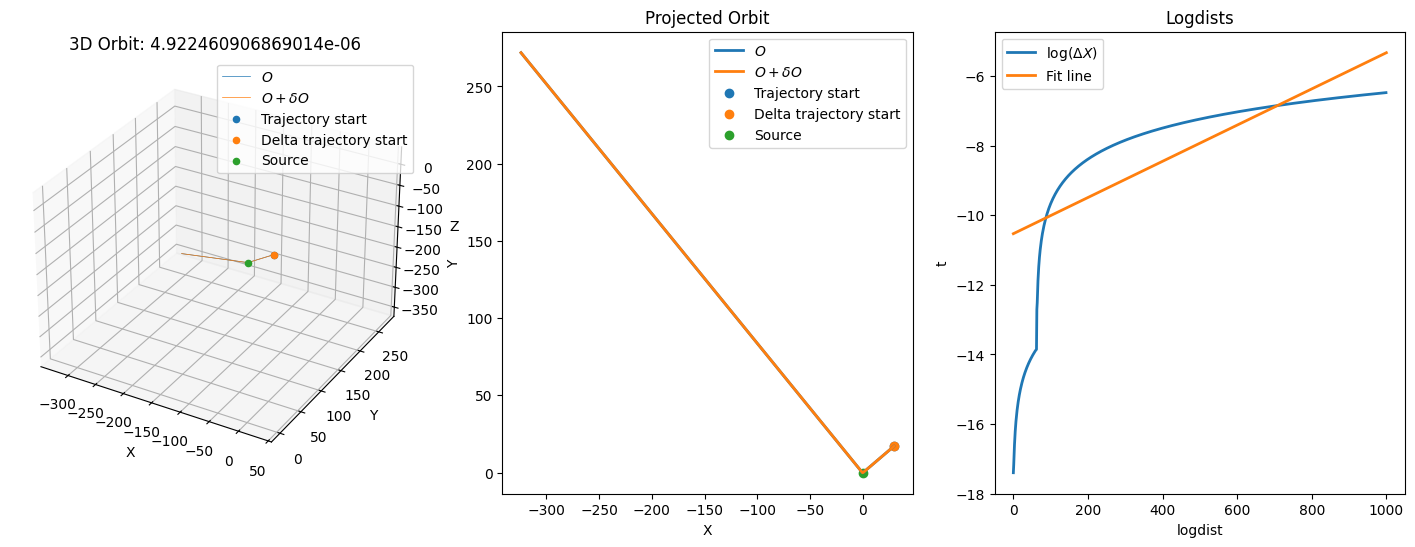

In [7]:
init_params = [29.65610122680664, 17.095962524414062, 14.473958015441895, -0.4648156762123108, -0.2711842656135559, -0.22552676498889923]
plot_from_init(init_params)

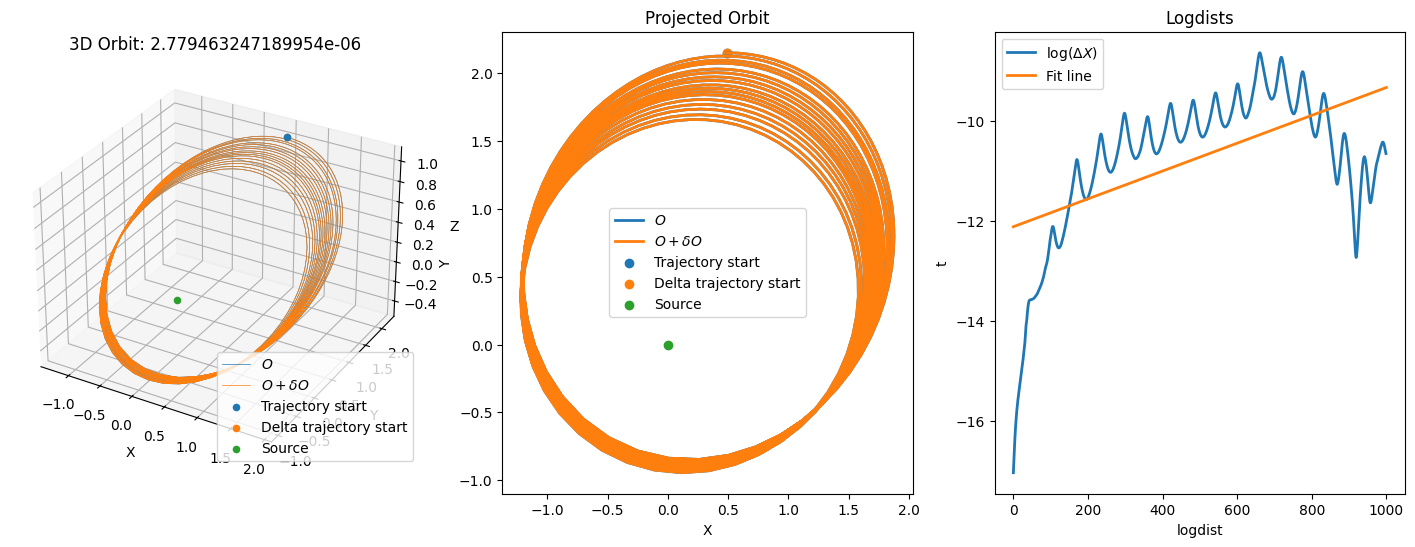

In [8]:
init_params = [0.48813504, 2.15189366, 1.02763376, 0.1, 0, 0]
plot_from_init(init_params)

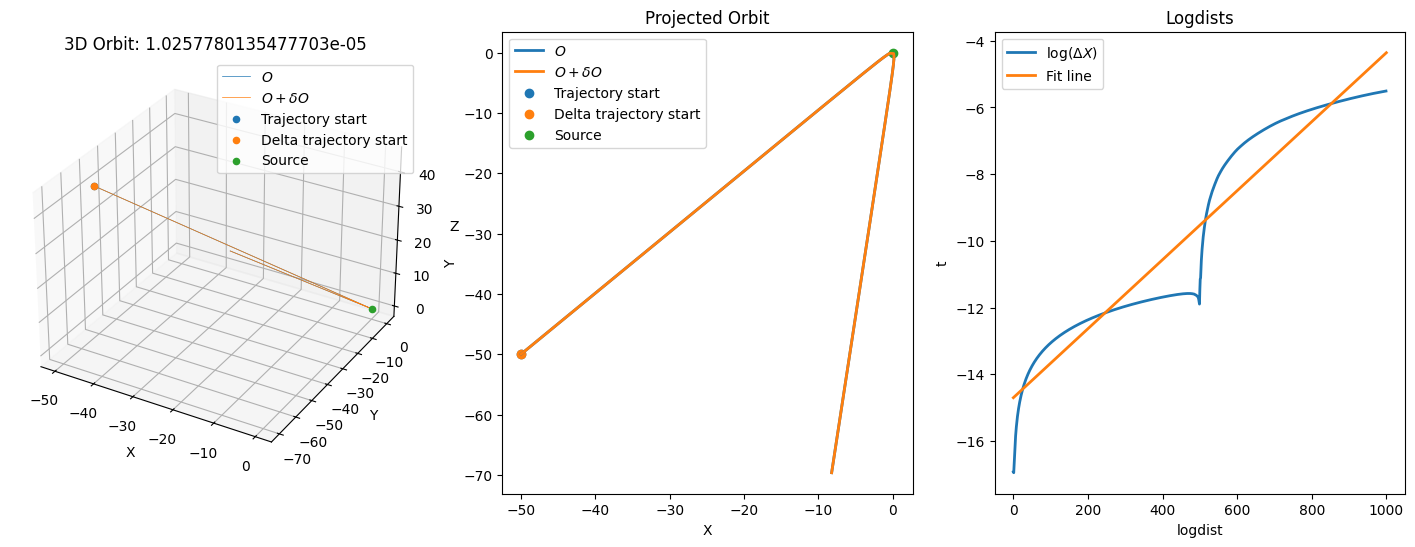

In [9]:
plot_from_init([-50.0, -50.0, 40.534263610839844, 0.09310219436883926, 0.09427925199270248, -0.07619106769561768])

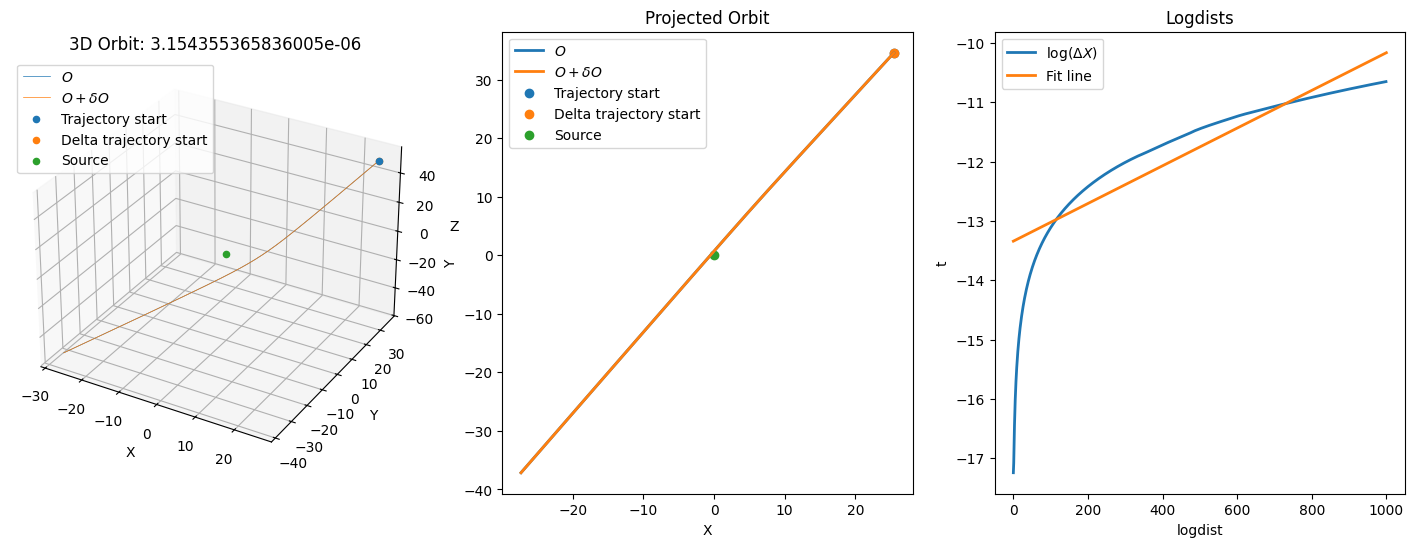

In [10]:
plot_from_init([25.467586517333984, 34.613948822021484, 50.0, -0.03907817602157593, -0.051330968737602234, -0.11453486979007721])